In [3]:
import os
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem import rdFMCS
import pandas as pd
import numpy as np

def load_clusters(directory, is_active=True):
    """Load molecule clusters from directory"""
    cluster_molecules = {}
    
    for cluster_file in sorted(os.listdir(directory)):
        if not cluster_file.endswith('.smi'):
            continue
        
        cluster_path = os.path.join(directory, cluster_file)
        
        try:
            with open(cluster_path, 'r') as f:
                smiles_list = [line.strip() for line in f if line.strip()]
        except IOError:
            print(f"Error reading file: {cluster_path}")
            continue
        
        # Extract cluster ID from filename
        cluster_id = cluster_file.replace('.smi', '')
        
        # Save valid molecules
        valid_mols = []
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                # Add hydrogens and compute 2D coordinates
                mol = Chem.AddHs(mol)
                AllChem.Compute2DCoords(mol)
                valid_mols.append(mol)
        
        if valid_mols:
            cluster_molecules[cluster_id] = valid_mols
            print(f"{'Active' if is_active else 'Inactive'} {cluster_id}: {len(valid_mols)} valid molecules")
    
    return cluster_molecules

def find_mcs_for_clusters(active_dir='Data/0.65t_0.5b_AA_merged/', inactive_dir='Data/0.65t_0.5b_AI_merged/'):
    # Dictionary to store molecules by cluster type and ID
    print("Loading active clusters...")
    active_clusters = load_clusters(active_dir, is_active=True)
    print("Loading inactive clusters...")
    inactive_clusters = load_clusters(inactive_dir, is_active=False)
    
    # Find MCS within each active cluster
    print("Finding MCS for active clusters...")
    active_mcs_results = {}
    for cluster_id, molecules in active_clusters.items():
        if len(molecules) > 1:  # Need at least 2 molecules for MCS
            try:
                mcs = rdFMCS.FindMCS(molecules, 
                                    atomCompare=rdFMCS.AtomCompare.CompareElements,
                                    bondCompare=rdFMCS.BondCompare.CompareOrder,
                                    ringMatchesRingOnly=True,
                                    completeRingsOnly=True)
                
                if mcs.smartsString:
                    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
                    if mcs_mol:
                        # Initialize ring info to prevent errors
                        mcs_mol.UpdatePropertyCache()
                        Chem.GetSSSR(mcs_mol)
                        
                        active_mcs_results[cluster_id] = {
                            'smarts': mcs.smartsString, 
                            'num_atoms': mcs.numAtoms,
                            'num_bonds': mcs.numBonds,
                            'mcs_mol': mcs_mol
                        }
                        print(f"Active cluster {cluster_id}: Found MCS with {mcs.numAtoms} atoms, {mcs.numBonds} bonds")
            except Exception as e:
                print(f"Error finding MCS for active cluster {cluster_id}: {e}")
    
    # Find MCS within each inactive cluster
    print("Finding MCS for inactive clusters...")
    inactive_mcs_results = {}
    for cluster_id, molecules in inactive_clusters.items():
        if len(molecules) > 1:  # Need at least 2 molecules for MCS
            try:
                mcs = rdFMCS.FindMCS(molecules, 
                                    atomCompare=rdFMCS.AtomCompare.CompareElements,
                                    bondCompare=rdFMCS.BondCompare.CompareOrder,
                                    ringMatchesRingOnly=True,
                                    completeRingsOnly=True)
                
                if mcs.smartsString:
                    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
                    if mcs_mol:
                        # Initialize ring info to prevent errors
                        mcs_mol.UpdatePropertyCache()
                        Chem.GetSSSR(mcs_mol)
                        
                        inactive_mcs_results[cluster_id] = {
                            'smarts': mcs.smartsString, 
                            'num_atoms': mcs.numAtoms,
                            'num_bonds': mcs.numBonds,
                            'mcs_mol': mcs_mol
                        }
                        print(f"Inactive cluster {cluster_id}: Found MCS with {mcs.numAtoms} atoms, {mcs.numBonds} bonds")
            except Exception as e:
                print(f"Error finding MCS for inactive cluster {cluster_id}: {e}")
    
    return {
        'active_mcs': active_mcs_results,
        'inactive_mcs': inactive_mcs_results
    }

# Run the first part of the analysis
results = find_mcs_for_clusters(
    active_dir='Data/0.65t_0.5b_AA_merged/', 
    inactive_dir='Data/0.65t_0.5b_AI_merged/'
)

# Save intermediate results
import pickle
with open('mcs_results_intermediate.pkl', 'wb') as f:
    pickle.dump(results, f)

print(f"Found MCS for {len(results['active_mcs'])} active clusters and {len(results['inactive_mcs'])} inactive clusters")

Loading active clusters...
Active merged_cluster_0: 6 valid molecules
Active merged_cluster_1: 6 valid molecules
Active merged_cluster_10: 9 valid molecules
Active merged_cluster_11: 4 valid molecules
Active merged_cluster_12: 4 valid molecules
Active merged_cluster_13: 7 valid molecules
Active merged_cluster_14: 4 valid molecules
Active merged_cluster_2: 9 valid molecules
Active merged_cluster_3: 9 valid molecules
Active merged_cluster_4: 10 valid molecules
Active merged_cluster_5: 5 valid molecules
Active merged_cluster_6: 11 valid molecules
Active merged_cluster_7: 10 valid molecules
Active merged_cluster_8: 11 valid molecules
Active merged_cluster_9: 4 valid molecules
Loading inactive clusters...
Inactive merged_cluster_0: 9 valid molecules
Inactive merged_cluster_1: 11 valid molecules
Inactive merged_cluster_10: 53 valid molecules
Inactive merged_cluster_100: 31 valid molecules
Inactive merged_cluster_101: 4 valid molecules
Inactive merged_cluster_102: 26 valid molecules
Inactive 

[11:46:13] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[11:46:13] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[11:46:13] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[11:46:13] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[11:46:13] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12


Inactive merged_cluster_110: 35 valid molecules
Inactive merged_cluster_111: 41 valid molecules
Inactive merged_cluster_112: 8 valid molecules
Inactive merged_cluster_113: 6 valid molecules
Inactive merged_cluster_114: 4 valid molecules
Inactive merged_cluster_115: 30 valid molecules
Inactive merged_cluster_116: 26 valid molecules
Inactive merged_cluster_117: 9 valid molecules
Inactive merged_cluster_118: 17 valid molecules
Inactive merged_cluster_119: 10 valid molecules
Inactive merged_cluster_12: 11 valid molecules
Inactive merged_cluster_120: 9 valid molecules


[11:46:13] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[11:46:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7


Inactive merged_cluster_121: 10 valid molecules
Inactive merged_cluster_122: 6 valid molecules
Inactive merged_cluster_123: 19 valid molecules
Inactive merged_cluster_124: 6 valid molecules
Inactive merged_cluster_125: 14 valid molecules
Inactive merged_cluster_126: 15 valid molecules
Inactive merged_cluster_127: 11 valid molecules
Inactive merged_cluster_128: 8 valid molecules
Inactive merged_cluster_129: 13 valid molecules
Inactive merged_cluster_13: 28 valid molecules
Inactive merged_cluster_130: 6 valid molecules
Inactive merged_cluster_131: 9 valid molecules
Inactive merged_cluster_132: 4 valid molecules
Inactive merged_cluster_133: 4 valid molecules
Inactive merged_cluster_134: 9 valid molecules
Inactive merged_cluster_135: 10 valid molecules
Inactive merged_cluster_136: 3 valid molecules
Inactive merged_cluster_137: 25 valid molecules
Inactive merged_cluster_138: 6 valid molecules
Inactive merged_cluster_139: 12 valid molecules
Inactive merged_cluster_14: 32 valid molecules


[11:46:14] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15


Inactive merged_cluster_140: 17 valid molecules
Inactive merged_cluster_141: 11 valid molecules
Inactive merged_cluster_142: 7 valid molecules
Inactive merged_cluster_143: 7 valid molecules
Inactive merged_cluster_144: 4 valid molecules
Inactive merged_cluster_145: 9 valid molecules
Inactive merged_cluster_146: 5 valid molecules
Inactive merged_cluster_147: 10 valid molecules
Inactive merged_cluster_148: 11 valid molecules
Inactive merged_cluster_149: 4 valid molecules
Inactive merged_cluster_15: 270 valid molecules
Inactive merged_cluster_150: 15 valid molecules
Inactive merged_cluster_151: 18 valid molecules
Inactive merged_cluster_152: 14 valid molecules
Inactive merged_cluster_153: 46 valid molecules
Inactive merged_cluster_154: 4 valid molecules
Inactive merged_cluster_155: 4 valid molecules
Inactive merged_cluster_156: 7 valid molecules
Inactive merged_cluster_157: 9 valid molecules
Inactive merged_cluster_158: 14 valid molecules
Inactive merged_cluster_159: 6 valid molecules
Ina

[11:46:15] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7 8 9 10 11


Inactive merged_cluster_206: 15 valid molecules
Inactive merged_cluster_207: 22 valid molecules
Inactive merged_cluster_208: 13 valid molecules
Inactive merged_cluster_209: 7 valid molecules
Inactive merged_cluster_21: 139 valid molecules
Inactive merged_cluster_210: 9 valid molecules
Inactive merged_cluster_211: 6 valid molecules
Inactive merged_cluster_212: 6 valid molecules
Inactive merged_cluster_213: 7 valid molecules
Inactive merged_cluster_214: 4 valid molecules
Inactive merged_cluster_215: 5 valid molecules
Inactive merged_cluster_216: 21 valid molecules
Inactive merged_cluster_217: 5 valid molecules
Inactive merged_cluster_218: 5 valid molecules
Inactive merged_cluster_219: 5 valid molecules
Inactive merged_cluster_22: 17 valid molecules
Inactive merged_cluster_220: 5 valid molecules
Inactive merged_cluster_221: 4 valid molecules
Inactive merged_cluster_222: 4 valid molecules


[11:46:16] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[11:46:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[11:46:16] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8


Inactive merged_cluster_223: 13 valid molecules
Inactive merged_cluster_224: 5 valid molecules
Inactive merged_cluster_225: 10 valid molecules
Inactive merged_cluster_226: 13 valid molecules
Inactive merged_cluster_227: 7 valid molecules
Inactive merged_cluster_228: 6 valid molecules
Inactive merged_cluster_229: 5 valid molecules
Inactive merged_cluster_23: 9 valid molecules
Inactive merged_cluster_230: 4 valid molecules
Inactive merged_cluster_231: 5 valid molecules
Inactive merged_cluster_232: 5 valid molecules
Inactive merged_cluster_233: 6 valid molecules
Inactive merged_cluster_234: 5 valid molecules
Inactive merged_cluster_235: 6 valid molecules
Inactive merged_cluster_236: 6 valid molecules
Inactive merged_cluster_24: 9 valid molecules
Inactive merged_cluster_25: 5 valid molecules
Inactive merged_cluster_26: 6 valid molecules
Inactive merged_cluster_27: 4 valid molecules
Inactive merged_cluster_28: 4 valid molecules
Inactive merged_cluster_29: 8 valid molecules
Inactive merged_c

[11:46:16] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4


Inactive merged_cluster_4: 90 valid molecules
Inactive merged_cluster_40: 17 valid molecules
Inactive merged_cluster_41: 8 valid molecules
Inactive merged_cluster_42: 4 valid molecules
Inactive merged_cluster_43: 13 valid molecules
Inactive merged_cluster_44: 7 valid molecules
Inactive merged_cluster_45: 24 valid molecules
Inactive merged_cluster_46: 61 valid molecules
Inactive merged_cluster_47: 58 valid molecules
Inactive merged_cluster_48: 4 valid molecules


[11:46:17] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12


Inactive merged_cluster_49: 4 valid molecules
Inactive merged_cluster_5: 9 valid molecules
Inactive merged_cluster_50: 30 valid molecules
Inactive merged_cluster_51: 18 valid molecules
Inactive merged_cluster_52: 18 valid molecules
Inactive merged_cluster_53: 4 valid molecules
Inactive merged_cluster_54: 7 valid molecules
Inactive merged_cluster_55: 14 valid molecules
Inactive merged_cluster_56: 7 valid molecules
Inactive merged_cluster_57: 11 valid molecules
Inactive merged_cluster_58: 20 valid molecules
Inactive merged_cluster_59: 32 valid molecules
Inactive merged_cluster_6: 220 valid molecules
Inactive merged_cluster_60: 10 valid molecules
Inactive merged_cluster_61: 15 valid molecules
Inactive merged_cluster_62: 4 valid molecules
Inactive merged_cluster_63: 5 valid molecules
Inactive merged_cluster_64: 20 valid molecules
Inactive merged_cluster_65: 4 valid molecules
Inactive merged_cluster_66: 4 valid molecules
Inactive merged_cluster_67: 41 valid molecules
Inactive merged_cluster

[11:46:18] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 32
[11:46:18] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10


Inactive merged_cluster_75: 19 valid molecules
Inactive merged_cluster_76: 19 valid molecules
Inactive merged_cluster_77: 7 valid molecules
Inactive merged_cluster_78: 4 valid molecules
Inactive merged_cluster_79: 5 valid molecules
Inactive merged_cluster_8: 34 valid molecules
Inactive merged_cluster_80: 10 valid molecules
Inactive merged_cluster_81: 10 valid molecules
Inactive merged_cluster_82: 71 valid molecules
Inactive merged_cluster_83: 9 valid molecules
Inactive merged_cluster_84: 4 valid molecules
Inactive merged_cluster_85: 4 valid molecules


[11:46:18] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[11:46:18] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16


Inactive merged_cluster_86: 28 valid molecules
Inactive merged_cluster_87: 4 valid molecules
Inactive merged_cluster_88: 5 valid molecules
Inactive merged_cluster_89: 4 valid molecules
Inactive merged_cluster_9: 270 valid molecules


[11:46:18] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[11:46:18] Can't kekulize mol.  Unkekulized atoms: 58 59 60 61 62 63 64 65 66


Inactive merged_cluster_90: 10 valid molecules
Inactive merged_cluster_91: 16 valid molecules
Inactive merged_cluster_92: 8 valid molecules
Inactive merged_cluster_93: 10 valid molecules
Inactive merged_cluster_94: 11 valid molecules
Inactive merged_cluster_95: 8 valid molecules
Inactive merged_cluster_96: 12 valid molecules
Inactive merged_cluster_97: 16 valid molecules
Inactive merged_cluster_98: 12 valid molecules
Inactive merged_cluster_99: 5 valid molecules
Finding MCS for active clusters...
Active cluster merged_cluster_0: Found MCS with 24 atoms, 25 bonds
Active cluster merged_cluster_1: Found MCS with 8 atoms, 8 bonds
Active cluster merged_cluster_10: Found MCS with 11 atoms, 11 bonds
Active cluster merged_cluster_11: Found MCS with 22 atoms, 23 bonds
Active cluster merged_cluster_12: Found MCS with 25 atoms, 24 bonds
Active cluster merged_cluster_13: Found MCS with 8 atoms, 8 bonds
Active cluster merged_cluster_14: Found MCS with 22 atoms, 23 bonds
Active cluster merged_cluste

[11:46:27] Explicit valence for atom # 1 N, 4, is greater than permitted


Active cluster merged_cluster_8: Found MCS with 10 atoms, 10 bonds
Active cluster merged_cluster_9: Found MCS with 10 atoms, 10 bonds
Finding MCS for inactive clusters...
Inactive cluster merged_cluster_0: Found MCS with 2 atoms, 1 bonds
Inactive cluster merged_cluster_1: Found MCS with 2 atoms, 1 bonds
Inactive cluster merged_cluster_10: Found MCS with 1 atoms, 0 bonds
Inactive cluster merged_cluster_100: Found MCS with 6 atoms, 6 bonds
Inactive cluster merged_cluster_101: Found MCS with 11 atoms, 11 bonds
Inactive cluster merged_cluster_102: Found MCS with 7 atoms, 7 bonds
Inactive cluster merged_cluster_103: Found MCS with 17 atoms, 18 bonds
Inactive cluster merged_cluster_104: Found MCS with 6 atoms, 6 bonds
Inactive cluster merged_cluster_105: Found MCS with 4 atoms, 3 bonds
Inactive cluster merged_cluster_106: Found MCS with 5 atoms, 4 bonds
Inactive cluster merged_cluster_107: Found MCS with 6 atoms, 5 bonds
Inactive cluster merged_cluster_108: Found MCS with 26 atoms, 26 bonds


[11:47:03] Explicit valence for atom # 1 N, 4, is greater than permitted


Inactive cluster merged_cluster_67: Found MCS with 16 atoms, 16 bonds
Inactive cluster merged_cluster_68: Found MCS with 8 atoms, 8 bonds
Inactive cluster merged_cluster_69: Found MCS with 8 atoms, 8 bonds
Inactive cluster merged_cluster_7: Found MCS with 1 atoms, 0 bonds
Inactive cluster merged_cluster_70: Found MCS with 7 atoms, 7 bonds
Inactive cluster merged_cluster_71: Found MCS with 1 atoms, 0 bonds
Inactive cluster merged_cluster_72: Found MCS with 7 atoms, 7 bonds
Inactive cluster merged_cluster_73: Found MCS with 12 atoms, 12 bonds
Inactive cluster merged_cluster_74: Found MCS with 12 atoms, 12 bonds
Inactive cluster merged_cluster_75: Found MCS with 3 atoms, 2 bonds
Inactive cluster merged_cluster_76: Found MCS with 7 atoms, 6 bonds
Inactive cluster merged_cluster_77: Found MCS with 6 atoms, 5 bonds
Inactive cluster merged_cluster_78: Found MCS with 6 atoms, 5 bonds
Inactive cluster merged_cluster_79: Found MCS with 1 atoms, 0 bonds
Inactive cluster merged_cluster_8: Found MC

[11:47:03] Explicit valence for atom # 6 N, 4, is greater than permitted


Inactive cluster merged_cluster_90: Found MCS with 11 atoms, 11 bonds
Inactive cluster merged_cluster_91: Found MCS with 12 atoms, 12 bonds
Inactive cluster merged_cluster_92: Found MCS with 6 atoms, 6 bonds
Inactive cluster merged_cluster_93: Found MCS with 10 atoms, 10 bonds
Inactive cluster merged_cluster_94: Found MCS with 7 atoms, 7 bonds
Inactive cluster merged_cluster_95: Found MCS with 12 atoms, 12 bonds
Inactive cluster merged_cluster_96: Found MCS with 15 atoms, 14 bonds
Inactive cluster merged_cluster_97: Found MCS with 7 atoms, 7 bonds
Inactive cluster merged_cluster_98: Found MCS with 9 atoms, 9 bonds
Inactive cluster merged_cluster_99: Found MCS with 4 atoms, 3 bonds
Found MCS for 14 active clusters and 233 inactive clusters


In [37]:
import pickle
from rdkit import Chem

def compare_active_inactive_mcs(active_mcs_dict, inactive_mcs_dict):
    """Compare each active MCS with each inactive MCS to find the exact common substructure."""
    
    matching_mcs_results = {}

    for active_id, active_data in active_mcs_dict.items():
        active_mcs = active_data.get('mcs_mol')
        if not active_mcs:
            continue
        
        active_mcs.UpdatePropertyCache()
        Chem.GetSSSR(active_mcs)  # Ensure ring info is initialized
        
        for inactive_id, inactive_data in inactive_mcs_dict.items():
            inactive_mcs = inactive_data.get('mcs_mol')
            if not inactive_mcs:
                continue
            
            inactive_mcs.UpdatePropertyCache()
            Chem.GetSSSR(inactive_mcs)
            
            try:
                # Find the exact common MCS
                if active_mcs.HasSubstructMatch(inactive_mcs) and inactive_mcs.HasSubstructMatch(active_mcs):
                    common_smarts = Chem.MolToSmarts(active_mcs)  # Get SMARTS of the common structure
                    
                    matching_mcs_results[(active_id, inactive_id)] = {
                        'common_mcs': common_smarts,
                        'active_smarts': active_data['smarts'],
                        'inactive_smarts': inactive_data['smarts']
                    }
                    
                    print(f"Common MCS found between Active {active_id} and Inactive {inactive_id}: {common_smarts}")
                    
            except Exception as e:
                print(f"Error comparing Active {active_id} with Inactive {inactive_id}: {e}")
    
    return matching_mcs_results

# Load MCS results from previous step
with open('mcs_results_intermediate.pkl', 'rb') as f:
    results = pickle.load(f)

# Extract active and inactive MCS dictionaries
active_mcs_dict = results['active_mcs']
inactive_mcs_dict = results['inactive_mcs']

# Run the comparison function
matching_mcs_results = compare_active_inactive_mcs(active_mcs_dict, inactive_mcs_dict)

# Save the final results
results['matching_mcs'] = matching_mcs_results

with open('mcs_results_final.pkl', 'wb') as f:
    pickle.dump(results, f)


Common MCS found between Active merged_cluster_1 and Inactive merged_cluster_124: [#6]1:&@[#6](:&@[#6](:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#1&!R])-&!@[#1&!R]
Common MCS found between Active merged_cluster_1 and Inactive merged_cluster_178: [#6]1:&@[#6](:&@[#6](:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#1&!R])-&!@[#1&!R]
Common MCS found between Active merged_cluster_1 and Inactive merged_cluster_51: [#6]1:&@[#6](:&@[#6](:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#1&!R])-&!@[#1&!R]
Common MCS found between Active merged_cluster_1 and Inactive merged_cluster_69: [#6]1:&@[#6](:&@[#6](:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#1&!R])-&!@[#1&!R]
Common MCS found between Active merged_cluster_3 and Inactive merged_cluster_124: [#6]1:,-;@[#6](:,-;@[#6](:,-;@[#6]:,-;@[#6]:,-;@[#6]:,-;@1)-&!@[#1&!R])-&!@[#1&!R]
Common MCS found between Active merged_cluster_3 and Inactive merged_cluster_178: [#6]1:,-;@[#6](:,-;@[#6](:,-;@[#6]:,-;@[#6]:,-;@[#6]:,-;@1)-&!@[#1&!R])-&!@[#1&!R]
Common MCS found between Active merged_cluster_3 and Inactiv

In [39]:
import pickle
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from matplotlib.gridspec import GridSpec

def visualize_mcs_comparison(results_file, active_cluster_id, inactive_cluster_id):

    # Load results
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    
    # Extract cluster data
    active_data = results['active_mcs'].get(active_cluster_id)
    inactive_data = results['inactive_mcs'].get(inactive_cluster_id)
    
    if not active_data or not inactive_data:
        print(f"Could not find data for active cluster {active_cluster_id} or inactive cluster {inactive_cluster_id}")
        return
    
    active_mol = active_data.get('mcs_mol')
    inactive_mol = inactive_data.get('mcs_mol')
    
    if not active_mol or not inactive_mol:
        print(f"MCS molecule not available for one or both clusters")
        return
    
    # Check if they're actually similar
    try:
        active_contains_inactive = active_mol.HasSubstructMatch(inactive_mol)
        inactive_contains_active = inactive_mol.HasSubstructMatch(active_mol)
        
        if not (active_contains_inactive or inactive_contains_active):
            print(f"Warning: No substructure match found between these clusters")
            match_type = "No match"
        else:
            match_types = []
            if active_contains_inactive:
                match_types.append("active contains inactive")
            if inactive_contains_active:
                match_types.append("inactive contains active")
            match_type = " & ".join(match_types)
            
    except Exception as e:
        print(f"Error comparing structures: {e}")
        match_type = "Error in comparison"
    
    # Find common substructure (MCS) between the two MCS molecules
    common_mcs = None
    if active_contains_inactive and inactive_contains_active:
        # If they contain each other, they must be identical or very similar
        common_mcs = active_mol
    elif active_contains_inactive:
        common_mcs = inactive_mol
    elif inactive_contains_active:
        common_mcs = active_mol
    
    # Get cluster molecules
    active_cluster_mols = []
    inactive_cluster_mols = []
    
    # Try different possible field names for molecule lists
    possible_fields = ['cluster_mols', 'molecules', 'mol_list']
    
    for field in possible_fields:
        if field in active_data and active_data[field]:
            active_cluster_mols = active_data[field]
            break
    
    for field in possible_fields:
        if field in inactive_data and inactive_data[field]:
            inactive_cluster_mols = inactive_data[field]
            break
    
    # Try to create from SMILES if no molecules found
    if not active_cluster_mols and 'smiles_list' in active_data:
        active_cluster_mols = [Chem.MolFromSmiles(s) for s in active_data['smiles_list'] if s]
    
    if not inactive_cluster_mols and 'smiles_list' in inactive_data:
        inactive_cluster_mols = [Chem.MolFromSmiles(s) for s in inactive_data['smiles_list'] if s]
    
    # Filter out None values
    active_cluster_mols = [m for m in active_cluster_mols if m is not None]
    inactive_cluster_mols = [m for m in inactive_cluster_mols if m is not None]
    
    # Generate 2D coordinates for better visualization if not already present
    for mol in [active_mol, inactive_mol] + active_cluster_mols + inactive_cluster_mols:
        if mol and mol.GetNumConformers() == 0:
            AllChem.Compute2DCoords(mol)
    
    # Create visualization
    print(f"Comparing Active Cluster {active_cluster_id} with Inactive Cluster {inactive_cluster_id}")
    print(f"Match type: {match_type}")
    print(f"Active cluster has {len(active_cluster_mols)} molecules, Inactive cluster has {len(inactive_cluster_mols)} molecules")
    
    # Display MCS structures
    fig = plt.figure(figsize=(15, 5))
    gs = GridSpec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Active MCS
    if active_mol:
        img = Draw.MolToImage(active_mol, size=(300, 300))
        ax1.imshow(img)
        ax1.set_title(f"Active MCS (Cluster {active_cluster_id})")
        ax1.axis('off')
    
    # Inactive MCS
    if inactive_mol:
        img = Draw.MolToImage(inactive_mol, size=(300, 300))
        ax2.imshow(img)
        ax2.set_title(f"Inactive MCS (Cluster {inactive_cluster_id})")
        ax2.axis('off')
    
    # Common MCS (if applicable)
    if common_mcs:
        img = Draw.MolToImage(common_mcs, size=(300, 300))
        ax3.imshow(img)
        ax3.set_title("Common Substructure")
        ax3.axis('off')
    else:
        ax3.text(0.5, 0.5, "No common substructure identified", 
                 ha='center', va='center', fontsize=12)
        ax3.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Display molecules in active cluster
    if active_cluster_mols:
        print(f"\nMolecules in Active Cluster {active_cluster_id} ({len(active_cluster_mols)} total):")
        
        # Calculate grid dimensions
        n_mols = len(active_cluster_mols)
        n_cols = min(4, n_mols)  # Maximum 4 columns
        n_rows = (n_mols + n_cols - 1) // n_cols
        
        # Create molecule grid
        grid_img = Draw.MolsToGridImage(
            active_cluster_mols,
            molsPerRow=n_cols,
            subImgSize=(250, 250),
            legends=[f"Molecule {i+1}" for i in range(n_mols)]
        )
        
        # Display the grid
        plt.figure(figsize=(15, 3 * n_rows))
        plt.imshow(grid_img)
        plt.axis('off')
        plt.title(f"Molecules in Active Cluster {active_cluster_id}")
        plt.tight_layout()
        plt.show()
    
    # Display molecules in inactive cluster
    if inactive_cluster_mols:
        print(f"\nMolecules in Inactive Cluster {inactive_cluster_id} ({len(inactive_cluster_mols)} total):")
        
        # For large clusters, limit display to first 20 molecules
        display_mols = inactive_cluster_mols[:20]
        
        # Calculate grid dimensions
        n_mols = len(display_mols)
        n_cols = min(4, n_mols)  # Maximum 4 columns
        n_rows = (n_mols + n_cols - 1) // n_cols
        
        # Create molecule grid
        grid_img = Draw.MolsToGridImage(
            display_mols,
            molsPerRow=n_cols,
            subImgSize=(250, 250),
            legends=[f"Molecule {i+1}" for i in range(n_mols)]
        )
        
        # Display the grid
        plt.figure(figsize=(15, 3 * n_rows))
        plt.imshow(grid_img)
        plt.axis('off')
        plt.title(f"Molecules in Inactive Cluster {inactive_cluster_id} (showing first {len(display_mols)} of {len(inactive_cluster_mols)})")
        plt.tight_layout()
        plt.show()
        
        if len(inactive_cluster_mols) > 20:
            print(f"Note: Only showing first 20 of {len(inactive_cluster_mols)} molecules in the inactive cluster")


Comparing Active Cluster merged_cluster_1 with Inactive Cluster merged_cluster_124
Match type: active contains inactive & inactive contains active
Active cluster has 0 molecules, Inactive cluster has 0 molecules


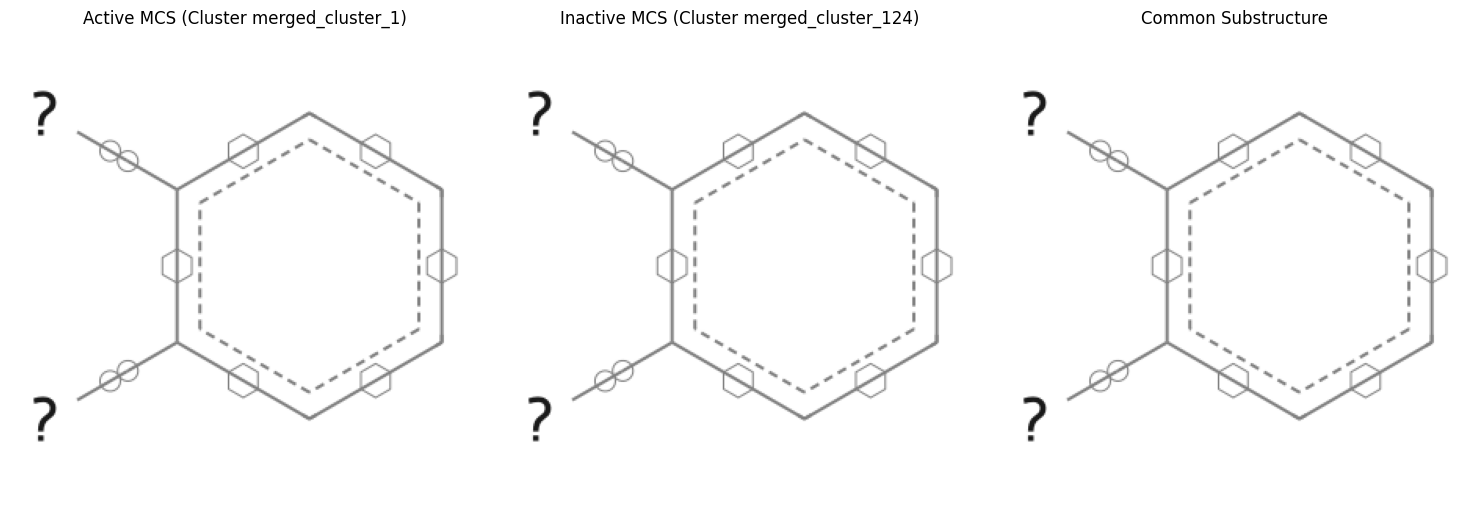

In [38]:
visualize_mcs_comparison('mcs_results_complete.pkl', 'merged_cluster_1', 'merged_cluster_124')

Comparing Active Cluster merged_cluster_1 with Inactive Cluster merged_cluster_51
Match type: active contains inactive & inactive contains active
Active cluster has 0 molecules, Inactive cluster has 0 molecules


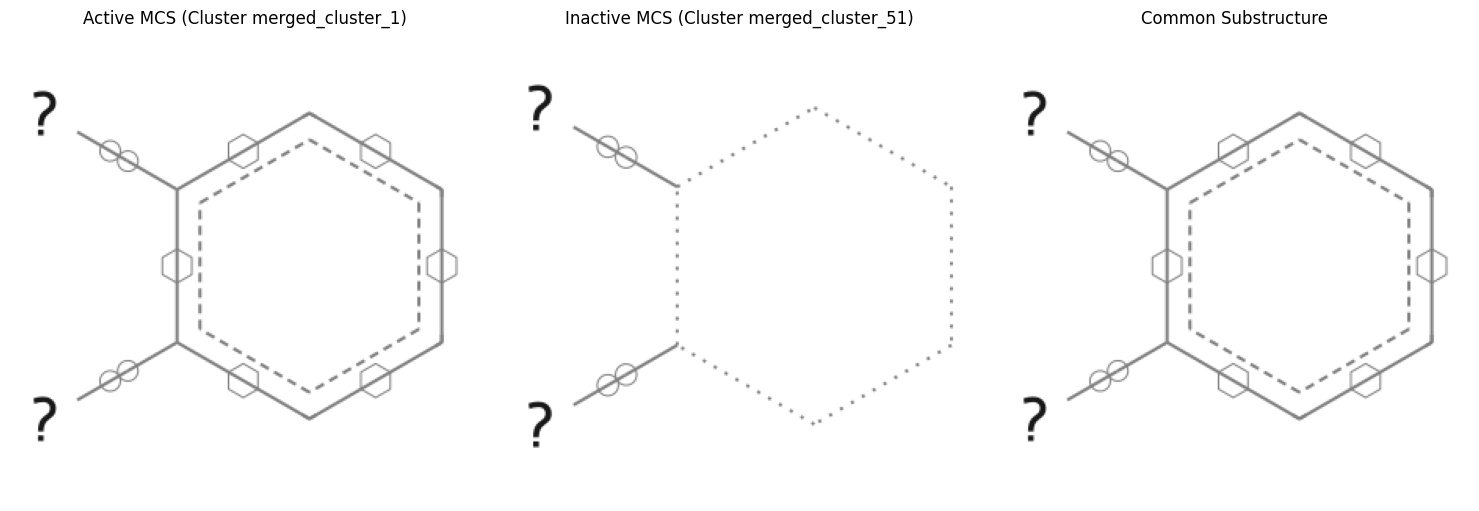

In [42]:
visualize_mcs_comparison('mcs_results_complete.pkl', 'merged_cluster_1', 'merged_cluster_51')